In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from tqdm import tqdm
import seaborn as sns

In [ ]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        self.game_over = False
        self.winner = None
        return self.get_state()

    def get_state(self):
        return tuple(self.board.flatten())

    def get_available_actions(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def make_move(self, action):
        i, j = action
        if self.board[i, j] != 0:
            return False

        self.board[i, j] = self.current_player

        if self.check_win(self.current_player):
            self.game_over = True
            self.winner = self.current_player
            return True

        if len(self.get_available_actions()) == 0:
            self.game_over = True
            return True

        self.current_player = 3 - self.current_player
        return True

    def check_win(self, player):
        for i in range(3):
            if all(self.board[i, :] == player) or all(self.board[:, i] == player):
                return True
        if (self.board[0, 0] == self.board[1, 1] == self.board[2, 2] == player) or \
           (self.board[0, 2] == self.board[1, 1] == self.board[2, 0] == player):
            return True
        return False


In [ ]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.9999, min_exploration=0.01):
        self.q_table = defaultdict(lambda: np.zeros((3, 3)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        self.training_history = {
            'wins': [], 'losses': [], 'draws': [],
            'exploration': [], 'q_changes': []
        }

    def get_action(self, state, available_actions):
        if random.random() < self.exploration_rate:
            return random.choice(available_actions)

        state_board = np.array(state).reshape(3, 3)
        q_values = self.q_table[state]
        masked_q = np.where(state_board == 0, q_values, -np.inf)
        return np.unravel_index(np.argmax(masked_q), masked_q.shape)

    def update_q_table(self, state, action, reward, next_state, done):
        old_q = self.q_table[state][action[0], action[1]].copy()

        current_q = self.q_table[state][action[0], action[1]]
        max_next_q = 0 if done else np.max(np.where(
            np.array(next_state).reshape(3,3) == 0,
            self.q_table[next_state],
            -np.inf
        ))

        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        self.q_table[state][action[0], action[1]] = new_q
        self.training_history['q_changes'].append(abs(new_q - old_q))

    def decay_exploration(self):
        self.exploration_rate = max(
            self.min_exploration,
            self.exploration_rate * self.exploration_decay
        )

    def record_result(self, result):
        self.training_history['wins'].append(1 if result == 1 else 0)
        self.training_history['losses'].append(1 if result == 2 else 0)
        self.training_history['draws'].append(1 if result == 0 else 0)
        self.training_history['exploration'].append(self.exploration_rate)

In [ ]:
def train_agent(episodes=100000):
    env = TicTacToe()
    agent = QLearningAgent()

    with tqdm(total=episodes, desc="Training agent") as pbar:
        for episode in range(episodes):
            state = env.reset()
            env.current_player = random.choice([1, 2])  # Random starter
            is_agent_turn = env.current_player == 1
            done = False

            while not done:
                if is_agent_turn:
                    available_actions = env.get_available_actions()
                    action = agent.get_action(state, available_actions)
                    env.make_move(action)
                    next_state = env.get_state()

                    if env.game_over:
                        reward = 1 if env.winner == 1 else (0.5 if env.winner is None else -1)
                        agent.update_q_table(state, action, reward, None, True)
                        agent.record_result(env.winner if env.winner == 1 else 0)
                        break
                    state = next_state
                else:
                    # Random opponent
                    available_actions = env.get_available_actions()
                    action = random.choice(available_actions)
                    env.make_move(action)

                    if env.game_over:
                        reward = -1 if env.winner == 2 else 0.5
                        agent.update_q_table(state, action, reward, None, True)
                        agent.record_result(env.winner if env.winner == 2 else 0)
                        break

                is_agent_turn = not is_agent_turn

            agent.decay_exploration()
            pbar.update(1)

    return agent

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def plot_training_metrics(agent):
    plt.figure(figsize=(18, 12))

    # 1. Win/Loss/Draw Rates
    plt.subplot(2, 2, 1)
    window = 1000
    wins = np.convolve(agent.training_history['wins'], np.ones(window)/window, 'valid')
    losses = np.convolve(agent.training_history['losses'], np.ones(window)/window, 'valid')
    draws = np.convolve(agent.training_history['draws'], np.ones(window)/window, 'valid')

    plt.plot(wins, label='Wins', color='green')
    plt.plot(losses, label='Losses', color='red')
    plt.plot(draws, label='Draws', color='blue')
    plt.title('Win/Loss/Draw Rates (Smoothed)')
    plt.xlabel('Episodes')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(alpha=0.3)

    # 2. Exploration Rate
    plt.subplot(2, 2, 2)
    plt.plot(agent.training_history['exploration'], color='purple')
    plt.title('Exploration Rate Decay')
    plt.xlabel('Episodes')
    plt.ylabel('ε')
    plt.grid(alpha=0.3)

    # 3. Q-Value Stability
    plt.subplot(2, 2, 3)
    q_changes = np.convolve(agent.training_history['q_changes'], np.ones(window)/window, 'valid')
    plt.plot(q_changes, color='orange')
    plt.title('Q-Value Changes (Stability)')
    plt.xlabel('Episodes')
    plt.ylabel('Average ΔQ')
    plt.grid(alpha=0.3)

    # 4. Modified Move Preference Heatmap (Max Q-values)
    plt.subplot(2, 2, 4)
    move_values = np.zeros((3, 3))
    move_counts = np.zeros((3, 3))

    for state in agent.q_table:
        state_board = np.array(state).reshape(3, 3)
        q_values = agent.q_table[state]

        # Only consider empty positions
        for i in range(3):
            for j in range(3):
                if state_board[i,j] == 0:
                    move_values[i,j] += q_values[i,j]
                    move_counts[i,j] += 1

    # Calculate average Q-values for each position
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_move_values = np.where(move_counts > 0, move_values/move_counts, 0)

    # Normalize to [0,1] for better visualization
    if np.max(avg_move_values) > 0:
        norm_move_values = (avg_move_values - np.min(avg_move_values)) / \
                         (np.max(avg_move_values) - np.min(avg_move_values))
    else:
        norm_move_values = avg_move_values

    sns.heatmap(norm_move_values, annot=True, fmt=".2f", cmap="YlGnBu",
                vmin=0, vmax=1, square=True, cbar=True,
                cbar_kws={'label': 'Normalized Q-value'})
    plt.title('Average Q-values by Position')
    plt.xticks([0.5,1.5,2.5], [1,2,3])
    plt.yticks([0.5,1.5,2.5], ['A','B','C'])

    plt.tight_layout()
    plt.show()

In [ ]:
def test_agent(agent, games=1000):
    env = TicTacToe()
    results = {'wins': 0, 'losses': 0, 'draws': 0}

    for _ in tqdm(range(games), desc="Testing agent"):
        state = env.reset()
        env.current_player = 1  # Agent plays first
        done = False

        while not done:
            if env.current_player == 1:
                action = agent.get_action(state, env.get_available_actions())
                env.make_move(action)
            else:
                action = random.choice(env.get_available_actions())
                env.make_move(action)

            state = env.get_state()
            if env.game_over:
                if env.winner == 1:
                    results['wins'] += 1
                elif env.winner == 2:
                    results['losses'] += 1
                else:
                    results['draws'] += 1
                break

    print(f"\nTest Results ({games} games):")
    print(f"Wins: {results['wins']} ({results['wins']/games*100:.1f}%)")
    print(f"Losses: {results['losses']} ({results['losses']/games*100:.1f}%)")
    print(f"Draws: {results['draws']} ({results['draws']/games*100:.1f}%)")

    plt.figure(figsize=(15, 8))
    plt.bar(results.keys(), results.values(), color=['green', 'red', 'blue'])
    plt.title('Agent Performance vs Random Opponent')
    plt.ylabel('Games')
    plt.show()

Training agent: 100%|██████████| 100000/100000 [00:18<00:00, 5523.47it/s]


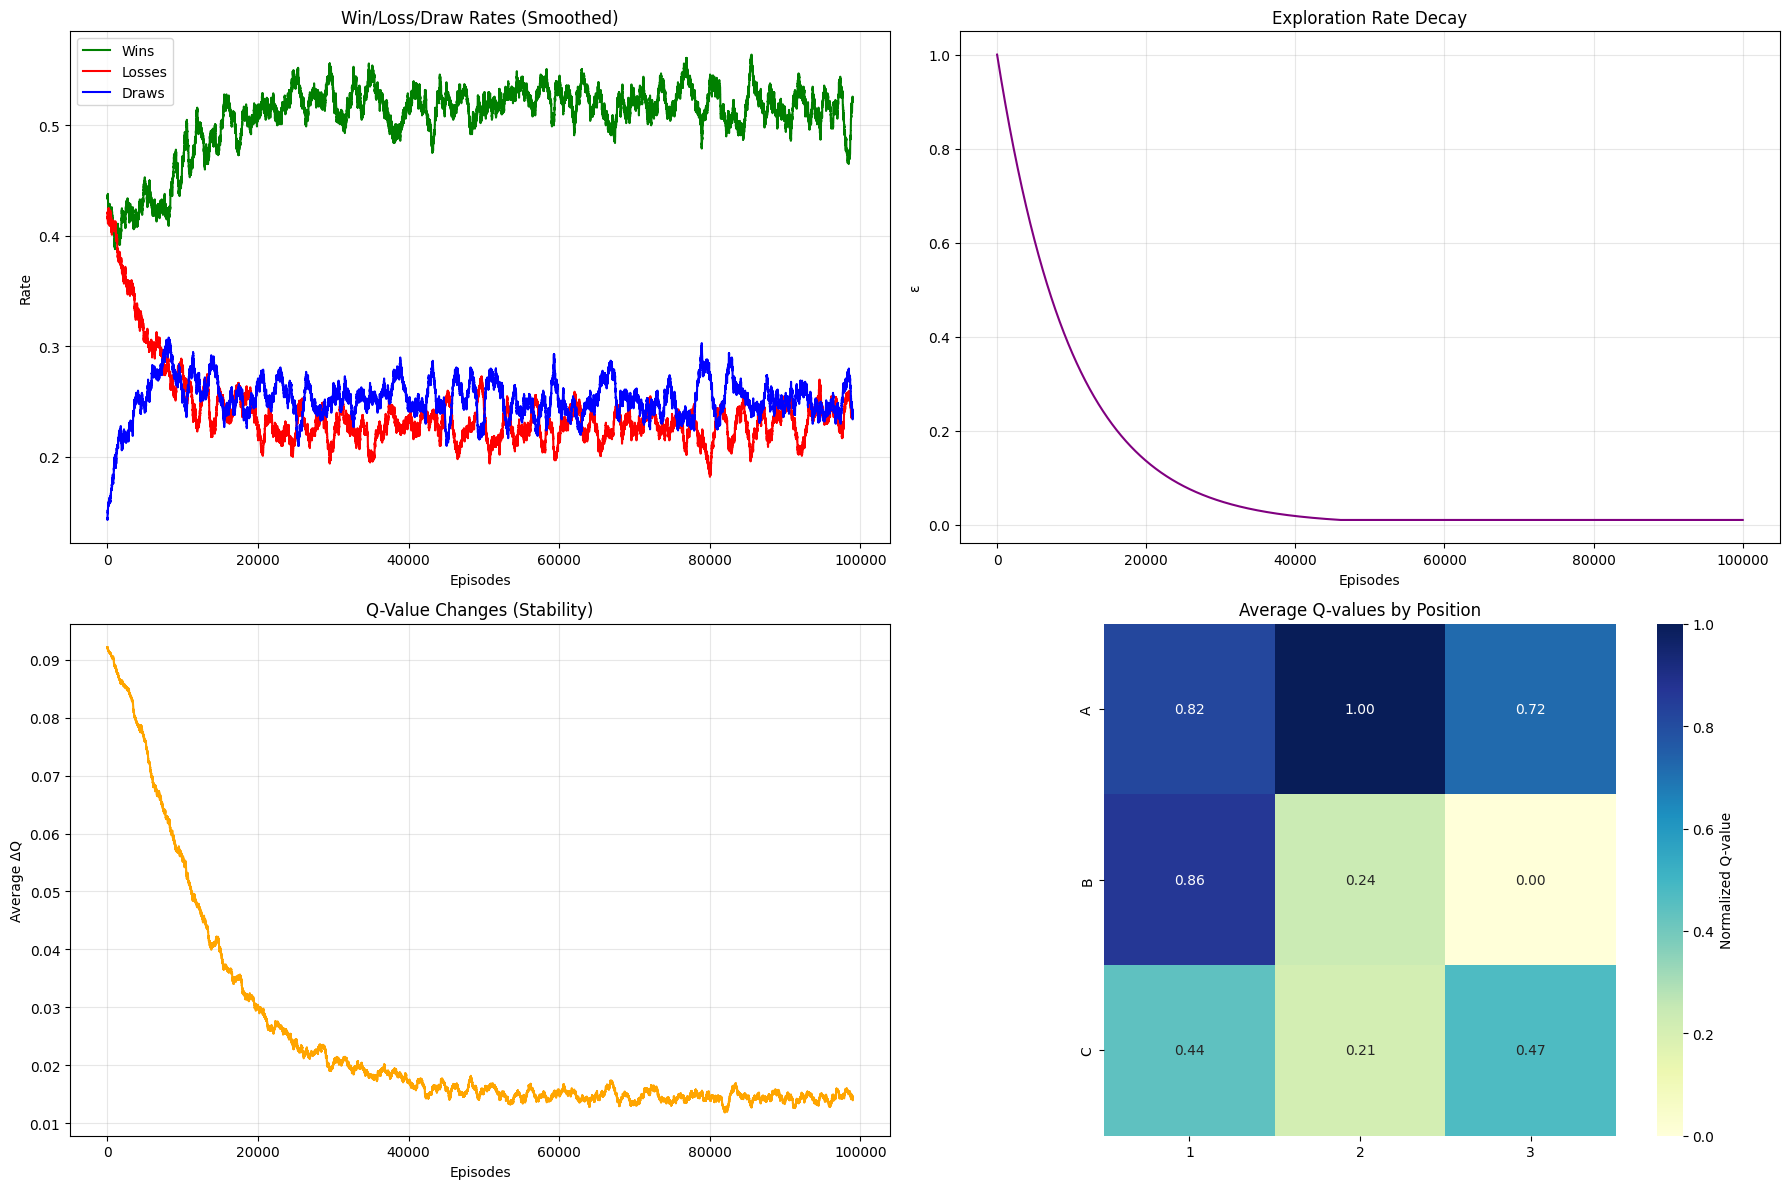

In [ ]:
agent = train_agent(episodes=100000)

# Plot metrics
plot_training_metrics(agent)

Testing agent: 100%|██████████| 1000/1000 [00:00<00:00, 5157.63it/s]



Test Results (1000 games):
Wins: 681 (68.1%)
Losses: 298 (29.8%)
Draws: 21 (2.1%)


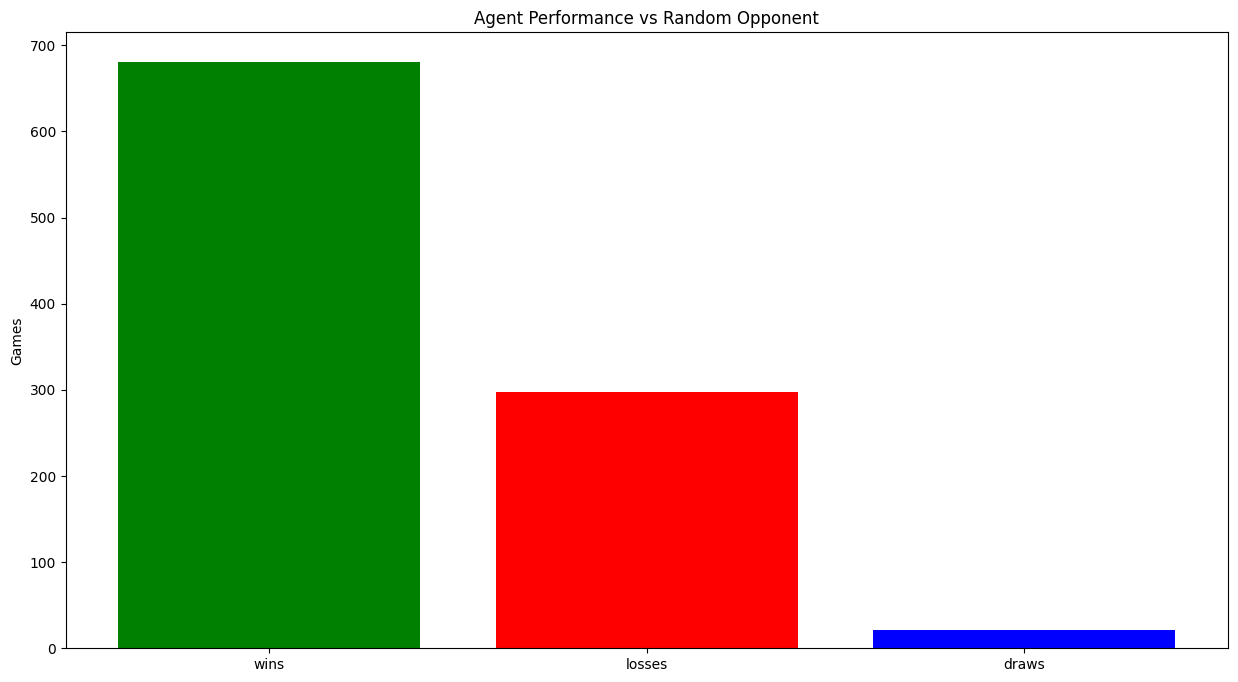

In [ ]:
# Test
test_agent(agent, games=1000)